In [1]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

from keras_ssd300 import ssd_300
from keras_ssd_loss import SSDLoss
from ssd_box_encode_decode_utils import SSDBoxEncoder, decode_y, decode_y2
from ssd_batch_generator import BatchGenerator

Using TensorFlow backend.


### 1. Introduction and building the model

The cell below sets a number of parameters that define the model architecture and then calls the function `ssd_300()` to build the model. The parameters as set below produce the original SSD300 architecture that was trained on the Pascal VOC datsets, i.e. they are all chosen to correspond exactly to their respective counterparts in the `.prototxt` file that defines the original Caffe implementation. Note that the anchor box scaling factors of the original SSD implementation vary depending on the datasets on which the authors trained their models. The scaling factors used for the MS COCO dataset are smaller than the scaling factors used for the Pascal VOC datasets, so keep that in mind if you want to reproduce the results from the paper. The scaling factors defined below are for the Pascal VOC datasets. The scaling factors are hard-coded as absolute pixel values in the `.prototxt`, but the relative scaling factors defined below produce exactly those absolute values at an image size of 300x300. The reason why the list of scaling factors has 7 elements while there are only 6 predictor layers is that the last scaling factor is used for the second aspect-ratio-1 box of the last predictor layer. See the documentation for details.

The original SSD does not clip the anchor box coordinates to lie within the image boundaries, so `limit_boxes` is set to `False`. Doing this may seem counterintuitive, but it seems to lead to better model performance according to Wei Liu.

Of course I could just hard-code everything with the original model parameters and this notebook would be a lot cleaner, but the way it's set up here, if you want to train a model with SSD300 architecture from scratch on an arbitrary dataset, you can change the configuration with just a few clicks. For example, if you wanted to train a model that is more suitable to detect smaller objects, you can just change the scale parameters below accordingly (not to imply that this is guaranteed to help, but you get the point: I prefer things to be tweakable with little effort).

The parameters set below are not only needed to build the model, but are also passed to the `SSDBoxEncoder` constructor in the subsequent cell, which is responsible for matching and encoding ground truth boxes and anchor boxes during training. In order to do that, it needs to know the anchor box specifications. It is for the same reason that `ssd_300()` does not only return the model itself, but also `predictor_sizes`, a list of the spatial sizes of the convolutional predictor layers - `SSDBoxEncoder` needs this information to know where the anchor boxes must be placed spatially.

The original Caffe implementation does pretty much everything inside a model layer: The ground truth boxes are matched and encoded inside [MultiBoxLossLayer](https://github.com/weiliu89/caffe/blob/ssd/src/caffe/layers/multibox_loss_layer.cpp), and box decoding, confidence thresholding and non-maximum suppression is performed in [DetectionOutputLayer](https://github.com/weiliu89/caffe/blob/ssd/src/caffe/layers/detection_output_layer.cpp). In contrast to that, in the current form of this implementation, ground truth box matching and encoding happens as part of the mini batch generation (i.e. outside of the model itself). To be specific, `BatchGenerator` calls the `encode_y()` method of `SSDBoxEncoder` and then yields the matched and encoded target tensor to be passed to the loss function. Similarly, the model here outputs the raw prediction tensor. The decoding and confidence thresholding is then performed by `decode_y()` and non-maximum suppression is performed by `greedy_nms()`, i.e. also outside the model. It's (almost) the same process in both cases, it's just that the code is organized differently between this implementation and the original Caffe implementation, which likely has performance implications, but I haven't measured it yet. I might look into incorporating all processing steps inside the model itself, but for now it was just easier to take the non-learning-relevant steps outside of Keras/Tensorflow. This is one advantage of Caffe: It's more convenient to write complex custom layers in plain C++ than to grapple with the Keras/Tensorflow API.

In [2]:
### Set up the model

# 1: Set some necessary parameters

img_height = 300 # Height of the input images
img_width = 300 # Width of the input images
img_channels = 3 # Number of color channels of the input images
n_classes = 2 # Number of classes including the background class, e.g. 21 for the Pascal VOC datasets
scales = [0.2]*7 # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets, the factors for the MS COCO dataset are smaller, namely [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
aspect_ratios = [[1.0]]*6
#     [0.5, 1.0, 2.0],
#                  [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
#                  [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
#                  [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
#                  [0.5, 1.0, 2.0],
#                  [0.5, 1.0, 2.0]] # The anchor box aspect ratios used in the original SSD300
two_boxes_for_ar1 = True
limit_boxes = False # Whether or not you want to limit the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are scaled as in the original implementation
coords = 'minmax' # Whether the box coordinates to be used as targets for the model should be in the 'centroids' or 'minmax' format, see documentation
normalize_coords = False

# 2: Build the Keras model (and possibly load some trained weights)

K.clear_session() # Clear previous models from memory.
# The output `predictor_sizes` is needed below to set up `SSDBoxEncoder`
model, predictor_sizes = ssd_300(image_size=(img_height, img_width, img_channels),
                                  n_classes=n_classes,
                                  min_scale=None, # You could pass a min scale and max scale instead of the `scales` list, but we're not doing that here
                                  max_scale=None,
                                  scales=scales,
                                  aspect_ratios_global=None,
                                  aspect_ratios_per_layer=aspect_ratios,
                                  two_boxes_for_ar1=two_boxes_for_ar1,
                                  limit_boxes=limit_boxes,
                                  variances=variances,
                                  coords=coords,
                                  normalize_coords=normalize_coords)
#model.load_weights('./ssd300_weights.h5', by_name=True) # You should load pre-trained weights for the modified VGG-16 base network here

### 2. Set up the training

The cell below sets up everything necessary to train the model. If you want to train the model on the Pascal VOC datasets, you need to change nothing except the filepaths to the dataset for both the train and validation generators. Remember to set the image set you would like to load.

The original implementation uses a batch size of 32 for training, but you might have to decrease that number based on your GPU memory.

I'm using an Adam optimizer with the same 0.001 initial learning rate that is stated in the paper, although of course learning rates are not entirely comparable between Adam and plain SGD with momentum.

`SSDLoss` is a custom Keras loss function that implements the multi-task log loss for classification and smooth L1 loss for localization. `neg_pos_ratio` and `alpha` are set as in the paper and `n_neg_min` is a rather unimportant optional parameter to make sure that a certain number of negative boxes always enters the loss function even if there are very few or no positive boxes in a batch, which should never happen anyway.

The `ssd_box_encoder` object, which, as explained above, knows how to match and encode the ground truth labels into the format that the model needs, is passed to the batch generator, which during training loads the next batch of images and labels, optionally performs data augmentation, and encodes the ground truth labels.

There are two parameters in the SSDBoxEncoder that you should note: `pos_iou_threshold` and `neg_iou_threshold`. The former determines the minimum Jaccard overlap between a ground truth box and an anchor box for a match and is set to 0.5, the value stated in the paper. The latter, `neg_iou_threshold`, is not in the paper, but it is useful to improve the learning process. It determines the maximum allowed Jaccard overlap between an anchor box and any ground truth box in order for that anchor box to be considered a negative box. This is useful because you want a clear margin between negative and positive boxes. An anchor box that almost contains an object should not be forced to learn to predict a negative box in such a case. 0.2 is a reasonable value that is used by various other object detection models.

In order to train the model on your own data just set the paths to the image files and labels in the batch generator constructor and read the documentation so you know what label format the generator expects. Also, make sure that your images are in whatever size you need them or use the resizing feature of the generator. The data augmentation features available in the generator are not identical to the techniques described in the paper, but they produce similar effects and work well nonetheless. If there is anything you don't understand, check out the documentation.

Caution: I would not recommend to try to train the model from scratch as it is now, it would likely learn nothing. You either need to load pre-trained weights for the modified VGG-16 base network as they did in the paper, or you need to modify the network to use dropout, batch normalization, decrease the depth, and/or play around with weight initialization to train from scratch.

In [3]:
### Set up training

batch_size = 4
images_dir = '/osn/SpaceNet-MOD/training/vehicles/rgb-ps-dra/DetectNet/300/images/'

# 3: Instantiate an Adam optimizer and the SSD loss function and compile the model

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=5e-05)

ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=0.1)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

# 4: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function 

ssd_box_encoder = SSDBoxEncoder(img_height=img_height,
                                img_width=img_width,
                                n_classes=n_classes,
                                predictor_sizes=predictor_sizes,
                                min_scale=None,
                                max_scale=None,
                                scales=scales,
                                aspect_ratios_global=None,
                                aspect_ratios_per_layer=aspect_ratios,
                                two_boxes_for_ar1=two_boxes_for_ar1,
                                limit_boxes=limit_boxes,
                                variances=variances,
                                pos_iou_threshold=0.4,
                                neg_iou_threshold=0.2,
                                coords=coords,
                                normalize_coords=normalize_coords)

# 5: Create the training set batch generator

classes = ['background', 'car']

train_dataset = BatchGenerator(images_path=images_dir,
                               include_classes='all',
                               box_output_format=['class_id', 'xmin', 'xmax', 'ymin', 'ymax'])

train_dataset.parse_csv(labels_path='/osn/share/ssd_cars/train_csv.csv',
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'])
#                         image_set_path='./Datasets/VOCdevkit/VOC2012/ImageSets/Main/',
#                         image_set='train.txt',
#                         classes=classes,
#                         exclude_truncated=False,
#                         exclude_difficult=False,
#                         ret=False)

train_generator = train_dataset.generate(batch_size=batch_size,
                                         train=True,
                                         ssd_box_encoder=ssd_box_encoder,
                                         equalize=False,
#                                          brightness=(0.5, 2, 0.5),
#                                          flip=0.5,
#                                          translate=((0, 30), (0, 30), 0.5),
                                         scale=(0.75, 1.2, 0.5),
#                                          random_crop=(300, 300, 1, 3), # This one is important because the Pascal VOC images vary in size
                                         crop=False,
                                         resize=False,
                                         gray=False,
                                         limit_boxes=True, # While the anchor boxes are not being clipped, 
                                                             #the ground truth boxes should be
                                         include_thresh=0.4,
                                         diagnostics=False)

n_train_samples = train_dataset.get_n_samples() # Get the number of samples in the training dataset to compute the epoch length below

# 6: Create the validation set batch generator

val_dataset = BatchGenerator(images_path=images_dir,
                             include_classes='all',
                             box_output_format=['class_id', 'xmin', 'xmax', 'ymin', 'ymax'])

val_dataset.parse_csv(labels_path='/osn/share/ssd_cars/val_csv.csv',
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'])


val_generator = val_dataset.generate(batch_size=batch_size,
                                     train=True,
                                     ssd_box_encoder=ssd_box_encoder,
                                     equalize=False,
                                     brightness=False,
                                     flip=False,
                                     translate=False,
                                     scale=False,
                                     random_crop=(300, 300, 1, 3),
                                     crop=False,
                                     resize=False,
                                     gray=False,
                                     limit_boxes=True,
                                     include_thresh=0.4,
                                     diagnostics=False)

n_val_samples = val_dataset.get_n_samples()

# 7: Define a simple learning rate schedule

def lr_schedule(epoch):
    if epoch <= 20: return 0.001
    else: return 0.0001

### 3. Run the training

Now that everything is set up, we're ready to start training. Set the number of epochs and the model name, the weights name in `ModelCheckpoint` and the filepaths to wherever you'd like to save the model. There isn't much more to say here, just execute the cell. If you get "out of memory" errors during training, reduce the batch size.

Training currently only monitors the validation loss, not the mAP. Contributions are welcome if you'd like to change that.

In [ ]:
### Run training

# 7: Run training

epochs = 100

history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = ceil(n_train_samples/batch_size),
                              epochs = epochs,
                              callbacks = [ModelCheckpoint('./ssd300_0_weights_epoch{epoch:02d}_loss{loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=False,
                                                           mode='auto',
                                                           period=1),
                                           LearningRateScheduler(lr_schedule),
                                           EarlyStopping(monitor='val_loss',
                                                         min_delta=0.001,
                                                         patience=2)],
                              validation_data = val_generator,
                              validation_steps = ceil(n_val_samples/batch_size))

model_name = 'ssd300_0'
model.save('./{}.h5'.format(model_name))
model.save_weights('./{}_weights.h5'.format(model_name))

print()
print("Model saved as {}.h5".format(model_name))
print("Weights also saved separately as {}_weights.h5".format(model_name))
print()

Epoch 1/100
2144/2145 [============================>.] - ETA: 0s - loss: 0.6297

### 4. Make predictions

Now let's make some predictions on the validation dataset with the trained model. We'll use the validation generator which we've already set up above. Feel free to change the batch size.

In [5]:
### Make predictions

# 1: Set the generator

predict_generator = val_dataset.generate(batch_size=1,
                                         train=False,
                                         equalize=False,
                                         brightness=False,
                                         flip=False,
                                         translate=False,
                                         scale=False,
                                         random_crop=(300, 300, 1, 3),
                                         crop=False,
                                         resize=False,
                                         gray=False,
                                         limit_boxes=True,
                                         include_thresh=0.4,
                                         diagnostics=False)

In [200]:
# 2: Generate samples

X, y_true, filenames = next(predict_generator)

i = 0 # Which batch item to look at

print("Image:", filenames[i])
print()
print("Ground truth boxes:\n")
print(y_true[i])

Image: 104001002B7A7300_135_132.png

Ground truth boxes:

[[  1   0   0  10  23]
 [  1   0   2   0  10]
 [  1   0   2  26  40]
 [  1   1  15 104 112]
 [  1 101 116 239 251]
 [  1 102 117 115 123]
 [  1 107 121 154 164]
 [  1 110 126 251 261]
 [  1 113 126 159 170]
 [  1 114 131 255 267]
 [  1 116 133 167 177]
 [  1 117 132 109 117]
 [  1 118 130 192 206]
 [  1 118 131 232 245]
 [  1 120 138 172 187]
 [  1 121 138 264 279]
 [  1 131 148 100 110]
 [  1 144 163 293 299]
 [  1 150 165 219 231]
 [  1 155 171  86  97]
 [  1 172 186 239 252]
 [  1 175 190  75  91]
 [  1 213 230 105 116]
 [  1 214 229 171 180]
 [  1 218 232 112 121]
 [  1 222 234 118 129]
 [  1 229 243  51  61]
 [  1 245 257 161 171]
 [  1 266 277  70  83]
 [  1 279 292  28  39]]


In [201]:
# 3: Make a prediction

y_pred = model.predict(X)

Now let's decode the raw prediction `y_pred`. The function `decode_y()` with arguments set as below follows the procedure of the original implementation: First a very low confidence threshold of 0.01 is applied to filter out the majority of the predicted boxes, then greedy non-maximum suppression is performed per class with an intersection-over-union threshold of 0.45, and out of what is left after that, the top 200 highest confidence boxes are returned. I don't understand why you would want to return 200 boxes when there are about two or three objects in a given image on average, but that's what the paper says.

The function `decode_y2()` performs an alternative procedure that is much more efficient and yields better results, so feel free to use that if you like. The documentation explains how it is different from `decode_y()`.

In [202]:
# 4: Decode the raw prediction `y_pred`

y_pred_decoded = decode_y(y_pred,
                          confidence_thresh=0.24,
                          iou_threshold=0.45,
                          top_k=200,
                          input_coords='minmax',
                          normalize_coords=normalize_coords,
                          img_height=img_height,
                          img_width=img_width)

print("Predicted boxes:\n")
print(y_pred_decoded[i])

Predicted boxes:

[[  1.00000000e+00   9.43718612e-01   1.17476593e+02   1.30974655e+02
    2.30389969e+02   2.45893784e+02]
 [  1.00000000e+00   9.33948398e-01   1.19342079e+02   1.33345367e+02
    1.70760254e+02   1.80092957e+02]
 [  1.00000000e+00   9.19218302e-01   1.72538406e+02   1.87639313e+02
    2.42637604e+02   2.53980957e+02]
 [  1.00000000e+00   9.06825960e-01   2.29868073e+02   2.45249008e+02
    5.02665329e+01   6.10874062e+01]
 [  1.00000000e+00   8.86245072e-01   1.20226379e+02   1.35415588e+02
    1.74327591e+02   1.84268387e+02]
 [  1.00000000e+00   8.78443360e-01   1.01718719e+02   1.16181030e+02
    1.14314713e+02   1.22126961e+02]
 [  1.00000000e+00   8.66455972e-01   2.15252090e+02   2.29322006e+02
    1.04740494e+02   1.12989632e+02]
 [  1.00000000e+00   8.53303313e-01   1.16328941e+02   1.30553864e+02
    1.91796082e+02   2.06120178e+02]
 [  1.00000000e+00   8.19219530e-01   2.46231079e+02   2.61692810e+02
    1.61005493e+02   1.70935669e+02]
 [  1.00000000e+00 

Finally, let's draw the predicted boxes onto the image in blue to visualize the result. Each predicted box says its confidence next to the category name. The ground truth boxes are also drawn onto the image in green for comparison.

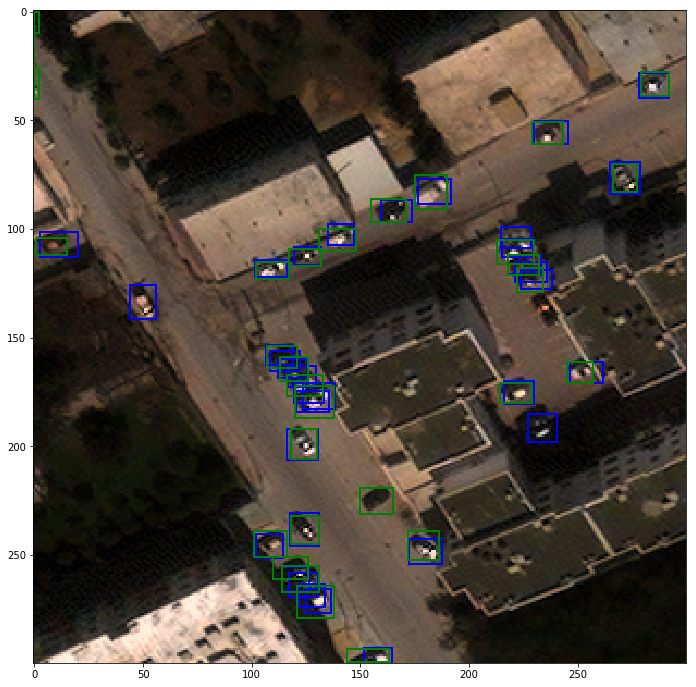

In [204]:
# 5: Draw the predicted boxes onto the image

plt.figure(figsize=(20,12))
plt.imshow(X[i])

current_axis = plt.gca()

for box in y_pred_decoded[i]:
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((box[2], box[4]), box[3]-box[2], box[5]-box[4], color='blue', fill=False, linewidth=2))  
#     current_axis.text(box[2], box[4], label, size='x-large', color='white', bbox={'facecolor':'blue', 'alpha':1.0})

for box in y_true[i]:
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((box[1], box[3]), box[2]-box[1], box[4]-box[3], color='green', fill=False, linewidth=2))  
#     current_axis.text(box[1], box[3], label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

# Testing/Validation 

In [95]:
val_dir = '/osn/SpaceNet-MOD/testing/rgb-ps-dra/300/'

In [93]:
import os
import rasterio
import pandas

In [206]:
results = []
fs = []
new_list = []
for n, p in results:
    if len(p)>0:
        for row in p[0]:
            new_list.append([n]+ row.tolist())
    

for r, d, filenames in os.walk(val_dir):
    for filename in filenames:
        if filename.endswith('png'):
            with rasterio.open(os.path.join(r, filename)) as f:
                fs.append(filename)
                x = f.read().transpose([1,2,0])[np.newaxis,:]
                p = model.predict(x)
                try:
                    d_p = decode_y(p,
                              confidence_thresh=0.15,
                              iou_threshold=0.35,
                              top_k=200,
                              input_coords='minmax',
                              normalize_coords=normalize_coords,
                              img_height=img_height,
                              img_width=img_width)
                    for row in d_p[0]:
                        results.append([filename]+ row.tolist())
                except ValueError as e:
                    pass
pandas.DataFrame(results, columns=['file_name', 'class_id', 'conf', 'xmin', 'xmax', 'ymin', 'ymax']).to_csv('ssd_results.csv')


/home/mla/.local/lib/python3.5/site-packages/rasterio/__init__.py:193: UserWarning: Dataset has no geotransform set.  Default transform will be applied (Affine.identity())
  s.start()
